In [2]:
# import libraries
import os
import random
import numpy as np
import cv2
from skimage.exposure import match_histograms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import keras 

In [3]:
# Constants
IMAGE_SIZE = (128, 128)  # Resize all images to this size
DATASET_PATH = r"C:\Users\Fabia\Desktop\data"  # Change to relative path without leading backslash
REFERENCE_IMAGE_PATH = r"C:\Users\Fabia\Desktop\data/reference_image.jpeg"  # Update reference image path
NUM_CLASSES = 2  # Update if you have more than 2 classes

In [4]:
# Load and preprocess dataset
def load_dataset(dataset_path):
    """
    Load all images and labels from the dataset folder.
    Assumes the folder contains subfolders named after class labels.
    """
    images = []
    labels = []
    class_names = []

    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            class_names.append(class_name)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    images.append(img_path)
                    labels.append(class_name)

    return images, labels, class_names

def preprocess_image(image_path, reference_image):
    """
    Preprocess a single image: grayscale conversion, resizing, and histogram matching.
    """
    # Load the input image
    image = cv2.imread(image_path)
    image_resized = cv2.resize(image, IMAGE_SIZE)  # Resize the image
    image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    # Match histogram using skimage
    reference_resized = cv2.resize(reference_image, IMAGE_SIZE)
    matched = match_histograms(image_gray, reference_resized)

    # Normalize pixel values to [0, 1]
    matched = matched / 255.0

    return matched

def prepare_data(images, labels, reference_image):
    """
    Preprocess all images and encode labels for training/testing.
    """
    processed_images = []
    for img_path in images:
        processed_image = preprocess_image(img_path, reference_image)
        processed_images.append(processed_image)

    # Convert images to numpy array and add channel dimension
    processed_images = np.array(processed_images).reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 1)

    # Encode labels
    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)
    return processed_images, encoded_labels, le.classes_

def build_model(input_shape, num_classes):
    """
    Build a simple CNN model.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def visualize_predictions(images, actual_labels, predicted_labels, class_names):
    """
    Visualize test images with actual and predicted labels.
    """
    num_images = min(10, len(images))  # Display at most 10 images
    plt.figure(figsize=(15, 10))

    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        image = images[i].reshape(IMAGE_SIZE)  # Reshape to original size
        plt.imshow(image, cmap='gray')
        plt.title(f"Actual: {class_names[actual_labels[i]]}\nPredicted: {class_names[predicted_labels[i]]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Epoch 1/10
83/83 [==============================] - 12s 133ms/step - loss: 0.7405 - accuracy: 0.5320 - val_loss: 0.6823 - val_accuracy: 0.5682
Epoch 2/10
83/83 [==============================] - 11s 136ms/step - loss: 0.6851 - accuracy: 0.5616 - val_loss: 0.6677 - val_accuracy: 0.5712
Epoch 3/10
83/83 [==============================] - 13s 155ms/step - loss: 0.6552 - accuracy: 0.6052 - val_loss: 0.6434 - val_accuracy: 0.6015
Epoch 4/10
83/83 [==============================] - 13s 152ms/step - loss: 0.6344 - accuracy: 0.6473 - val_loss: 0.6335 - val_accuracy: 0.6288
Epoch 5/10
83/83 [==============================] - 12s 147ms/step - loss: 0.6005 - accuracy: 0.6602 - val_loss: 0.6385 - val_accuracy: 0.6379
Epoch 6/10
83/83 [==============================] - 12s 146ms/step - loss: 0.5893 - accuracy: 0.6830 - val_loss: 0.6796 - val_accuracy: 0.6318
Epoch 7/10
83/83 [==============================] - 12s 145ms/step - loss: 0.5793 - accuracy: 0.6883 - val_loss: 0.6102 - val_accuracy: 0.6500

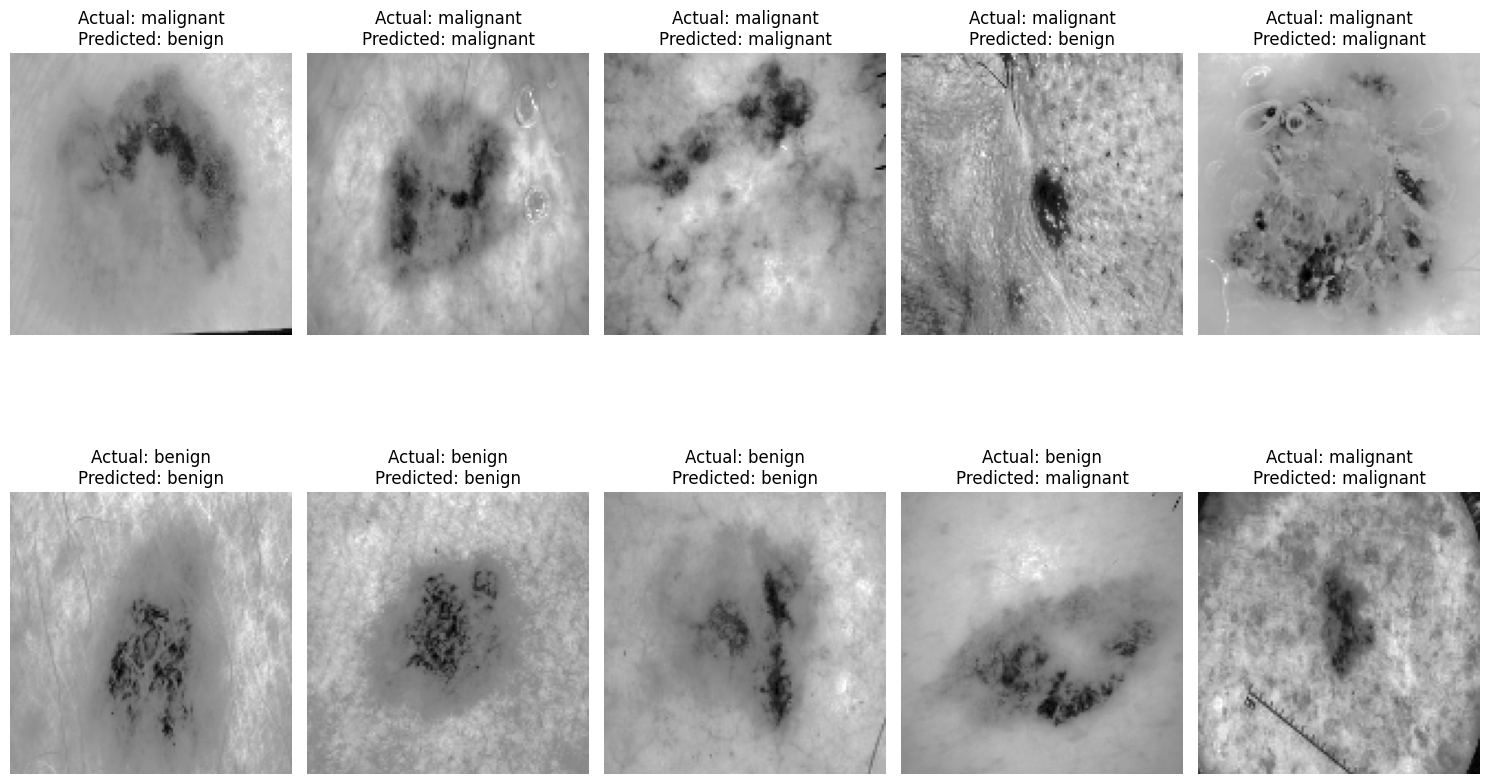

In [5]:
# Load dataset
images, labels, class_names = load_dataset(DATASET_PATH)

# Load reference image for histogram matching
reference_image = cv2.imread(REFERENCE_IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

# Preprocess data
processed_images, encoded_labels, class_labels = prepare_data(images, labels, reference_image)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(processed_images, encoded_labels, test_size=0.2, random_state=42)

# Build and train the model
model = build_model(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1), num_classes=len(class_labels))
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Make predictions on test data
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Visualize test images with actual vs. predicted labels
visualize_predictions(X_test, y_test, predicted_labels, class_labels)

In [6]:
# export the model to the models folder 
keras.saving.save_model(model, 'non_bias_model.keras')

In [8]:
# load the model and show summary 
model.save("non_bias_model_new.h5", save_format="h5")
model.summary()

c:\Users\Fabia\.virtualenvs\backend-KvJJLMcj\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 128)               7